In [232]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import time as tt
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from constants import G, KPC_TO_KM, GYR_TO_S
from utils import get_track, get_q

from spray_base import generate_stream_spray_base
from spray import generate_stream_spray
from streak import generate_stream_streak
from first import generate_stream_first
from second import generate_stream_second
from utils import inference_first, inference_second

from likelihoods import log_likelihood_spray, log_likelihood_streak, log_likelihood_first, log_likelihood_spray_base


## First, start by defining the paramters

In [229]:
# Flattened NFW halo
logM, Rs, q = 12.0, 25.0, 0.8
dirx, diry, dirz = 1., 1., 1. #1.0, 1.0, 1.0

# Plummer Sattelite
logm, rs = 8.0, 2.0 

# Initial conditions
x0, y0, z0 = 100.0, 0.0, 0.0     # Position in kpc
vx0, vy0, vz0 = 0.0, 200.0, 0.0  # Velocity in kpc/Gyr

# Integration time
time = 4. # Gyr
alpha = 1.

params = (logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha)

## (1) Spray Method

In [128]:
start = tt.time()
theta_stream_spray, xv_stream_spray, theta_sat_spray, xv_sat_spray = generate_stream_spray(params,  123)
end = tt.time()
print(f"Time taken to generate stream using Spray: {end - start:.2f} seconds")
count_spray, theta_bin_spray, r_bin_spray, w_bin_spray = get_track(theta_stream_spray, xv_stream_spray[:, 0], xv_stream_spray[:, 1])

Time taken to generate stream using Spray: 1.17 seconds


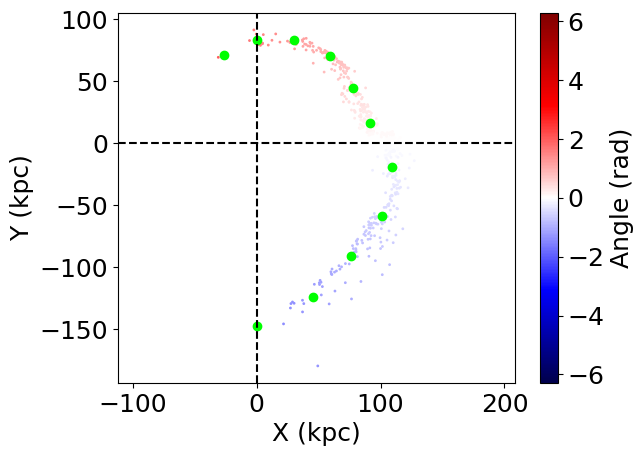

In [129]:
plt.scatter(xv_stream_spray[:, 0], xv_stream_spray[:, 1], c=theta_stream_spray, s=1, cmap='seismic', vmin=-2*np.pi, vmax=2*np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin_spray*np.cos(theta_bin_spray), r_bin_spray*np.sin(theta_bin_spray), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (2) Streak Method

In [194]:
start = tt.time()
theta_stream_streak, xv_stream_streak, theta_sat_streak, xv_sat_streak = generate_stream_streak(params,  seed=111)
end = tt.time()
print(f"Time taken to generate stream using Streak: {end - start:.2f} seconds")
count_streak, theta_bin_streak, r_bin_streak, w_bin_streak = get_track(theta_stream_streak, xv_stream_streak[:, 0], xv_stream_streak[:, 1])

Time taken to generate stream using Streak: 0.01 seconds


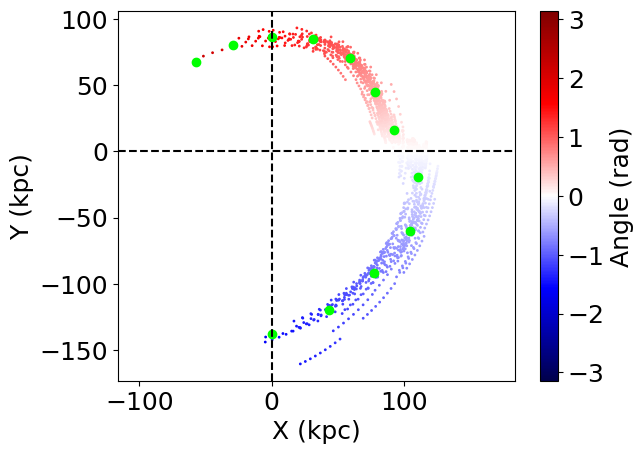

In [195]:
plt.scatter(xv_stream_streak[:, 0], xv_stream_streak[:, 1], c=theta_stream_streak, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin_streak*np.cos(theta_bin_streak), r_bin_streak*np.sin(theta_bin_streak), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

In [276]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import time as tt
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from constants import G, KPC_TO_KM, GYR_TO_S
from utils import get_track, get_q

from spray_base import generate_stream_spray_base
from spray import generate_stream_spray
from streak import generate_stream_streak
from first import generate_stream_first
from second import generate_stream_second
from utils import inference_first, inference_second

from likelihoods import log_likelihood_spray, log_likelihood_streak, log_likelihood_first, log_likelihood_spray_base

N = 100
other_seed = np.random.randint(1, 1000)

# seed_count_chi2, count_chi2 = [], []
# seed_r_chi2, r_chi2 = [], []
# seed_r_chi, r_chi = [], []

baseline, spray, streak, first = [], [], [], []
# seed_w_chi2, w_chi2 = [], []
# seed_w_chi, w_chi = [], []
for i in tqdm(range(N), leave=True):
    with open(f"./MockStreams/seed{i}/dict_stream.pkl", "rb") as f:
        dict_data = pickle.load(f)
    params = dict_data['params']
    min_count = 100
    arg_take = dict_data['count'] > min_count
    r_sig = 0.02*dict_data['r_bin'][arg_take]

    theta_stream, xv_stream, theta_sat, xv_sat = generate_stream_spray_base(params,  seed=other_seed)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])
    # baseline.extend(abs(dict_data['r_bin'] - r_bin)[arg_take] / r_sig)
    baseline.append(np.mean(abs(dict_data['r_bin'] - r_bin)[arg_take] / r_sig))

    theta_stream, xv_stream, theta_sat, xv_sat = generate_stream_spray(params,  seed=other_seed)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])
    # spray.extend(abs(dict_data['r_bin'] - r_bin)[arg_take] / r_sig)
    spray.append(np.mean(abs(dict_data['r_bin'] - r_bin)[arg_take] / r_sig))

    theta_stream, xv_stream, theta_sat, xv_sat = generate_stream_streak(params,  seed=other_seed)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])
    # streak.extend(abs(dict_data['r_bin'] - r_bin)[arg_take] / r_sig)
    streak.append(np.mean(abs(dict_data['r_bin'] - r_bin)[arg_take] / r_sig))

    theta_stream_first, xv_stream_first, theta_sat_first, xv_sat_first, S, dS, refs, weights_stream, samples, weights_samples = generate_stream_first(params,  seed=other_seed)
    theta_samples, xv_samples, weights_samples = inference_first(theta_stream_first, xv_stream_first, refs, weights_stream, S, seed=other_seed, disp_x=0.3, disp_v=1.)
    count_first, theta_bin_first, r_bin, w_bin_first = get_track(theta_samples, xv_samples[:, 0], xv_samples[:, 1])
    # first.extend(abs(dict_data['r_bin'] - r_bin)[arg_take] / r_sig)
    first.append(np.mean(abs(dict_data['r_bin'] - r_bin)[arg_take] / r_sig))
baseline = np.array(baseline)
spray = np.array(spray)
streak = np.array(streak)
first = np.array(first)
    # count_chi2.extend(count)

    # r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]
    # r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]

    # w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]
    # w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]

    # r_chi2.extend((r_diff / (0.02*dict_data['r_bin'][dict_data['count'] > min_count])))
    # r_chi.extend((r_bias / (0.02*dict_data['r_bin'][dict_data['count'] > min_count])))

    # w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > min_count]))
    # w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > min_count]))

    # theta_stream, xv_stream, theta_sat, xv_sat = generate_stream_spray(params,  seed=other_seed)
    # count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])
    # seed_count_chi2.extend(count)

    # min_count = 100
    # r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]
    # r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]

    # w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]
    # w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]

    # seed_r_chi2.extend((r_diff / (0.02*dict_data['r_bin'][dict_data['count'] > min_count])))
    # seed_r_chi.extend((r_bias / (0.02*dict_data['r_bin'][dict_data['count'] > min_count])))

    # seed_w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > min_count]))
    # seed_w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > min_count]))

# seed_r_chi2 = jnp.array(seed_r_chi2)
# seed_r_chi = jnp.array(seed_r_chi)
# r_chi2 = jnp.array(r_chi2)
# r_chi = jnp.array(r_chi)

# seed_w_chi2 = jnp.array(seed_w_chi2)
# seed_w_chi = jnp.array(seed_w_chi)
# w_chi2 = jnp.array(w_chi2)
# w_chi = jnp.array(w_chi)

# count_chi2 = np.array(count_chi2)
# seed_count_chi2 = np.array(seed_count_chi2)

100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


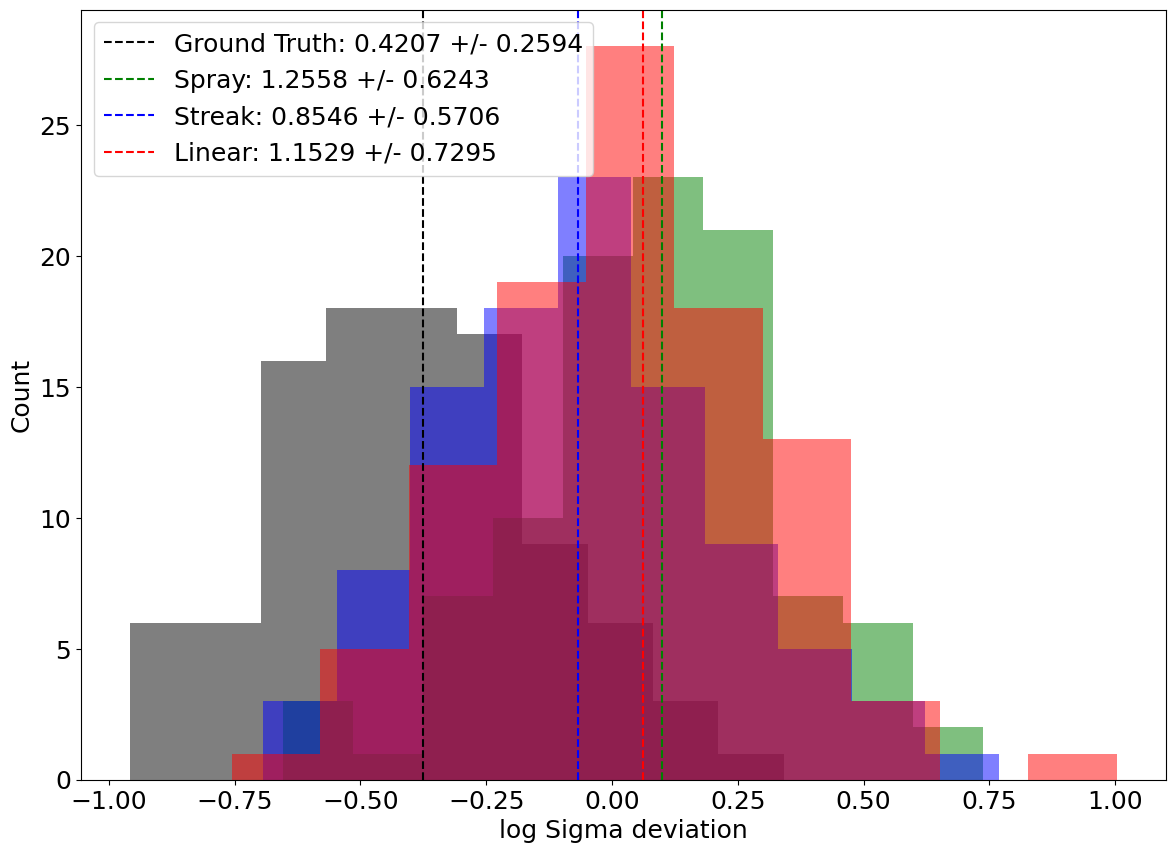

In [277]:
plt.figure(figsize=(14, 10))
plt.ylabel('Count')
plt.xlabel('log Sigma deviation')
# bins = np.histogram_bin_edges(np.log10(streak), bins='auto')
bins = 10
plt.hist(np.log10(baseline), bins=bins, alpha=0.5, color='k')
plt.hist(np.log10(spray), bins=bins, alpha=0.5, color='g')
plt.hist(np.log10(streak), bins=bins, alpha=0.5, color='b')
plt.hist(np.log10(first), bins=bins, alpha=0.5, color='r')
plt.axvline(np.median(np.log10(baseline)), color='k', linestyle='--', label=f'Ground Truth: {np.median(baseline):.4f} +/- {(np.percentile(baseline, 84) - np.percentile(baseline, 16)) / 2:.4f}')
plt.axvline(np.median(np.log10(spray)), color='g', linestyle='--', label=f'Spray: {np.median(spray):.4f} +/- {(np.percentile(spray, 84) - np.percentile(spray, 16)) / 2:.4f}')
plt.axvline(np.median(np.log10(streak)), color='b', linestyle='--', label=f'Streak: {np.median(streak):.4f} +/- {(np.percentile(streak, 84) - np.percentile(streak, 16)) / 2:.4f}')
plt.axvline(np.median(np.log10(first)), color='r', linestyle='--', label=f'Linear: {np.median(first):.4f} +/- {(np.percentile(first, 84) - np.percentile(first, 16)) / 2:.4f}')
plt.legend(loc='upper left')

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

def gaussian_overlap(mu1, sigma1, mu2, sigma2):
    f1 = lambda x: norm.pdf(x, mu1, sigma1)
    f2 = lambda x: norm.pdf(x, mu2, sigma2)
    integrand = lambda x: np.minimum(f1(x), f2(x))
    val, _ = quad(integrand, -np.inf, np.inf)
    return val

baseline_median = np.median(np.log10(baseline))
baseline_std = (np.percentile(np.log10(baseline), 84) - np.percentile(np.log10(baseline), 16)) / 2
spray_median = np.median(np.log10(spray))
spray_std = (np.percentile(np.log10(spray), 84) - np.percentile(np.log10(spray), 16)) / 2
streak_median = np.median(np.log10(streak))
streak_std = (np.percentile(np.log10(streak), 84) - np.percentile(np.log10(streak), 16)) / 2
first_median = np.median(np.log10(first))
first_std = (np.percentile(np.log10(first), 84) - np.percentile(np.log10(first), 16)) / 2

# Example: two N(0,1) and N(1,1)
print(gaussian_overlap(baseline_median, baseline_std, spray_median, spray_std))
print(gaussian_overlap(baseline_median, baseline_std, streak_median, streak_std))
print(gaussian_overlap(baseline_median, baseline_std, first_median, first_std))

0.4407965626637356
0.5387161957245272
0.4562432944667928


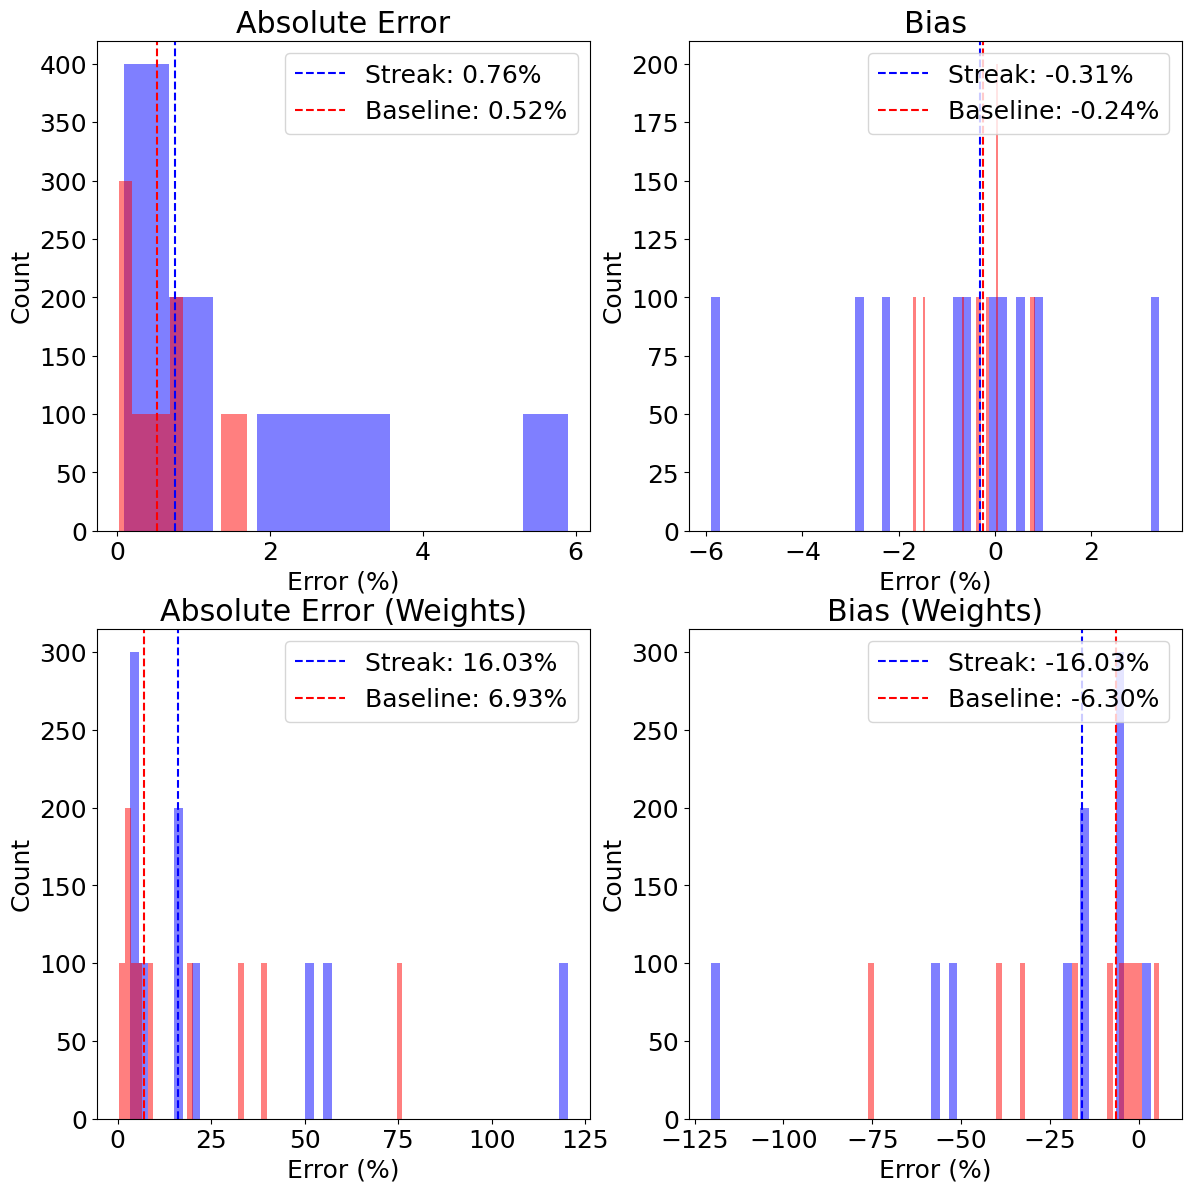

In [100]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.title('Absolute Error')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*r_chi2, alpha=0.5, color='b')
plt.hist(100*seed_r_chi2, alpha=0.5, color='r')
plt.axvline(np.median(100*r_chi2), color='b', linestyle='--', label=f'Streak: {np.median(100*r_chi2):.2f}%')
plt.axvline(np.median(100*seed_r_chi2), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_r_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.title('Bias')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*r_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_r_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*r_chi), color='b', linestyle='--', label=f'Streak: {np.median(100*r_chi):.2f}%')
plt.axvline(np.median(100*seed_r_chi), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_r_chi):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 3)
plt.title('Absolute Error (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi2, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi2, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*w_chi2), color='b', linestyle='--', label=f'Streak: {np.median(100*w_chi2):.2f}%')
plt.axvline(np.median(100*seed_w_chi2), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_w_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.title('Bias (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*w_chi), color='b', linestyle='--', label=f'Streak: {np.median(100*w_chi):.2f}%')
plt.axvline(np.median(100*seed_w_chi), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_w_chi):.2f}%')
plt.legend(loc='upper right')


(-2.0, 2.0)

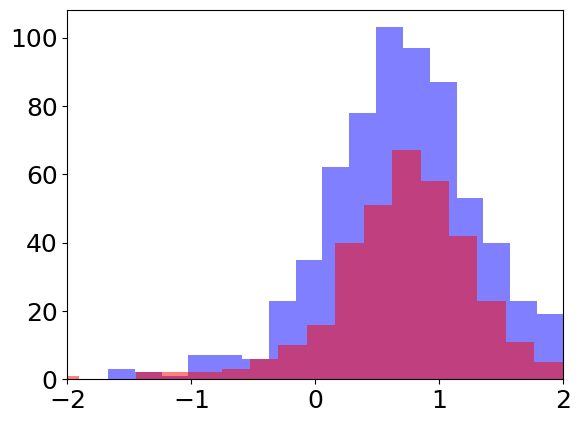

In [198]:
max_count = 5
plt.hist(np.log10(100*r_chi2[np.where(seed_count_chi2<=max_count)]), bins=20, alpha=0.5, color='b')
plt.hist(np.log10(100*seed_r_chi2[np.where(seed_count_chi2<=max_count)]), bins=20, alpha=0.5, color='r');
plt.xlim([-2, 2])

## (3) 1st order method

In [7]:
%reload_ext autoreload  
%autoreload 2
from first import *

start = tt.time()
theta_stream_first, xv_stream_first, theta_sat_first, xv_sat_first, S, dS, refs, weights_stream, samples, weights_samples = generate_stream_first(params,  seed=111+1)
theta_samples, xv_samples, weights_samples = inference_first(theta_stream_first, xv_stream_first, refs, weights_stream, S, seed=111, disp_x=0.1, disp_v=1.)
end = tt.time()
print(f"Time taken to generate stream using First: {end - start:.2f} seconds")
count_first, theta_bin_first, r_bin_first, w_bin_first = get_track(theta_samples, xv_samples[:, 0], xv_samples[:, 1], weights_samples)

TypeError: mul got incompatible shapes for broadcasting: (400,), (500,).

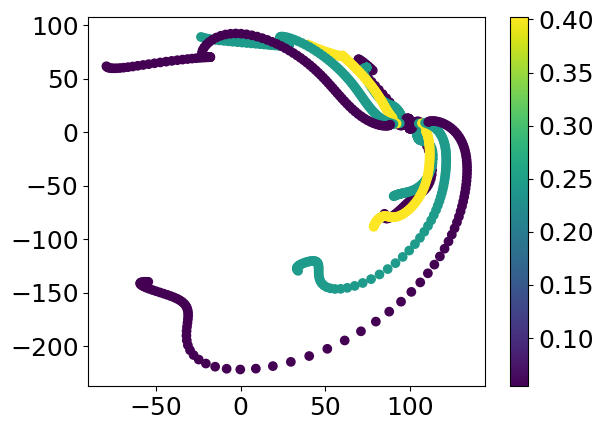

In [8]:
plt.scatter(xv_stream_first[:, 0], xv_stream_first[:, 1], c=weights_stream)
plt.colorbar()

In [141]:
sigmas = jnp.array([-2, -1, 0, 1, 2]) #jnp.linspace(-sigma_range, sigma_range, N_PARTICLES//2//N_STEPS+2)[1:-1]
fixed_sigma = jnp.tile(jnp.repeat(sigmas, 2), N)
weights = jnp.exp(-0.5 * sigmas**2)
weights /= jnp.sum(weights)
fixed_weights  = jnp.tile(jnp.repeat(weights, 2), N)

In [142]:
fixed_weights

Array([0.05448869, 0.05448869, 0.24420136, 0.24420136, 0.40261996,
       0.40261996, 0.24420136, 0.24420136, 0.05448869, 0.05448869,
       0.05448869, 0.05448869, 0.24420136, 0.24420136, 0.40261996,
       0.40261996, 0.24420136, 0.24420136, 0.05448869, 0.05448869,
       0.05448869, 0.05448869, 0.24420136, 0.24420136, 0.40261996,
       0.40261996, 0.24420136, 0.24420136, 0.05448869, 0.05448869,
       0.05448869, 0.05448869, 0.24420136, 0.24420136, 0.40261996,
       0.40261996, 0.24420136, 0.24420136, 0.05448869, 0.05448869,
       0.05448869, 0.05448869, 0.24420136, 0.24420136, 0.40261996,
       0.40261996, 0.24420136, 0.24420136, 0.05448869, 0.05448869,
       0.05448869, 0.05448869, 0.24420136, 0.24420136, 0.40261996,
       0.40261996, 0.24420136, 0.24420136, 0.05448869, 0.05448869,
       0.05448869, 0.05448869, 0.24420136, 0.24420136, 0.40261996,
       0.40261996, 0.24420136, 0.24420136, 0.05448869, 0.05448869,
       0.05448869, 0.05448869, 0.24420136, 0.24420136, 0.40261

In [147]:
_, theta_bin_first, r_bin_first, w_bin_first = get_track(theta_samples, xv_samples[:, 0], xv_samples[:, 1], weights_samples)
_, _, r_bin_noweights, _ = get_track(theta_samples, xv_samples[:, 0], xv_samples[:, 1], jnp.ones_like(weights_samples))

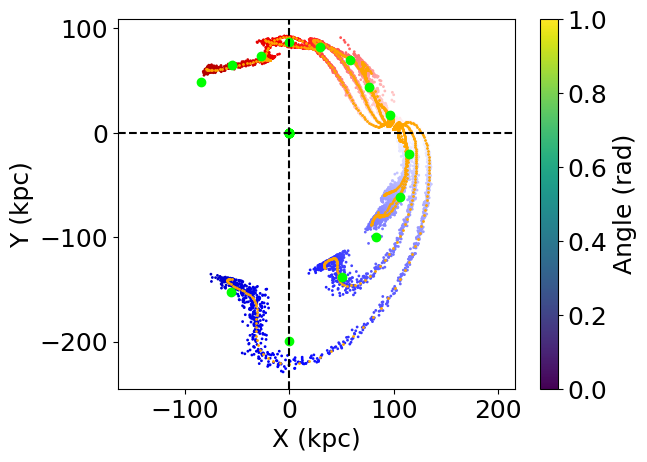

In [148]:
plt.scatter(xv_samples[:, 0], xv_samples[:, 1], c=theta_samples, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.scatter(xv_stream_first[:, 0], xv_stream_first[:, 1], c='orange', s=1)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin_first*np.cos(theta_bin_first), r_bin_first*np.sin(theta_bin_first), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

In [104]:
N = 100
other_seed = np.random.randint(1, 1000)

seed_count_chi2, count_chi2 = [], []
seed_r_chi2, r_chi2 = [], []
seed_r_chi, r_chi = [], []

seed_w_chi2, w_chi2 = [], []
seed_w_chi, w_chi = [], []
for i in tqdm(range(N), leave=True):

    with open(f"./MockStreams/seed{i}/dict_stream.pkl", "rb") as f:
        dict_data = pickle.load(f)

    params = dict_data['params']

    theta_stream_first, xv_stream_first, theta_sat_first, xv_sat_first, S, dS, refs, weights_stream, samples, weights_samples = generate_stream_first(params,  seed=111+1)
    theta_samples, xv_samples, weights_samples = inference_first(theta_stream_first, xv_stream_first, refs, weights_stream, S, seed=111, disp_x=0.1, disp_v=1.)
    _, theta_bin_first, r_bin_first, w_bin_first = get_track(theta_samples, xv_samples[:, 0], xv_samples[:, 1], jnp.ones_like(len(xv_stream)/10)) #, weights_samples)
    count_chi2.extend(count_first)

    min_count = 100
    r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]
    r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]

    w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]
    w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]

    r_chi2.extend((r_diff / dict_data['r_bin'][dict_data['count'] > min_count]))
    r_chi.extend((r_bias / dict_data['r_bin'][dict_data['count'] > min_count]))

    w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > min_count]))
    w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > min_count]))

    theta_stream, xv_stream, theta_sat, xv_sat = generate_stream_spray(params,  seed=other_seed)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1], jnp.ones_like(len(xv_stream)/10))
    seed_count_chi2.extend(count)

    min_count = 100
    r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]
    r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]

    w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]
    w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]

    seed_r_chi2.extend((r_diff / dict_data['r_bin'][dict_data['count'] > min_count]))
    seed_r_chi.extend((r_bias / dict_data['r_bin'][dict_data['count'] > min_count]))

    seed_w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > min_count]))
    seed_w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > min_count]))

seed_r_chi2 = jnp.array(seed_r_chi2)
seed_r_chi = jnp.array(seed_r_chi)
r_chi2 = jnp.array(r_chi2)
r_chi = jnp.array(r_chi)

seed_w_chi2 = jnp.array(seed_w_chi2)
seed_w_chi = jnp.array(seed_w_chi)
w_chi2 = jnp.array(w_chi2)
w_chi = jnp.array(w_chi)

count_chi2 = np.array(count_chi2)
seed_count_chi2 = np.array(seed_count_chi2)

100%|██████████| 100/100 [00:09<00:00, 10.87it/s]


(-2.0, 2.0)

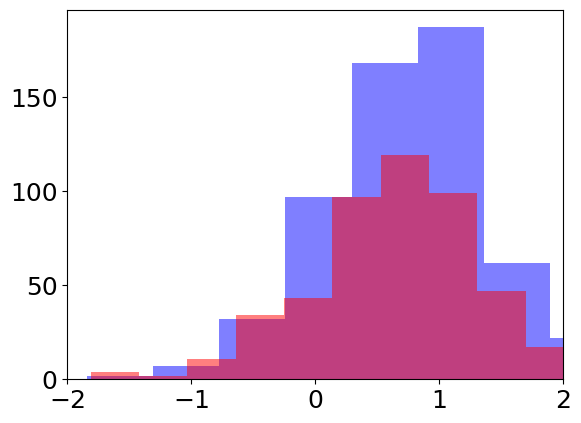

In [175]:
max_count = 10
plt.hist(np.log10(100*r_chi2[np.where(seed_count_chi2<=max_count)]), bins=10, alpha=0.5, color='b')
plt.hist(np.log10(100*seed_r_chi2[np.where(seed_count_chi2<=max_count)]), bins=10, alpha=0.5, color='r');
plt.xlim([-2, 2])

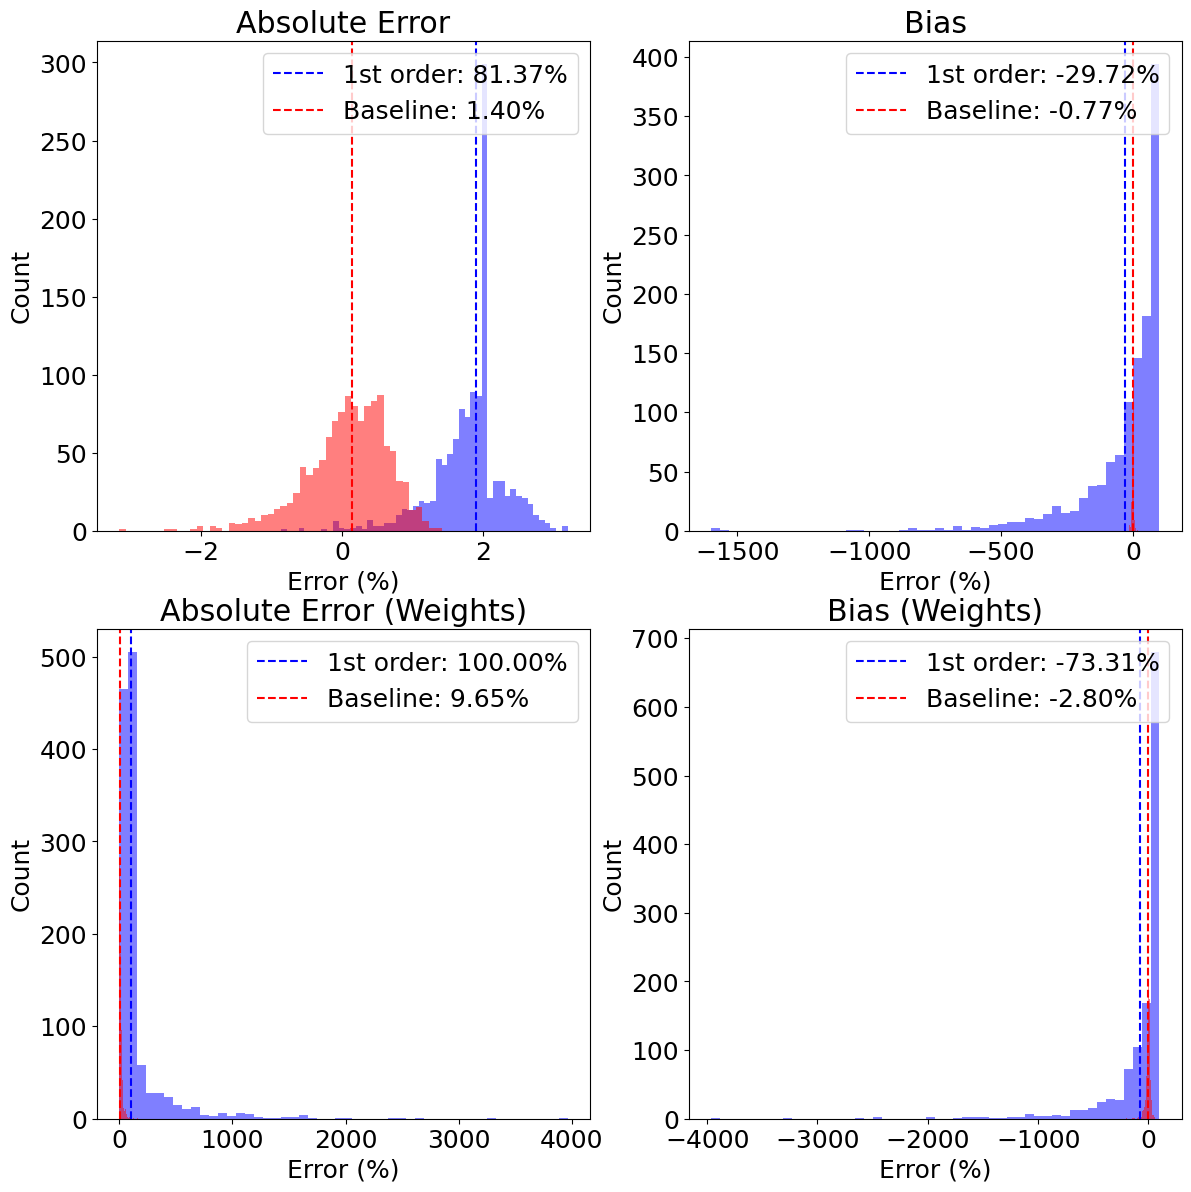

In [106]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.title('Absolute Error')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(np.log10(100*r_chi2), bins=50, alpha=0.5, color='b')
plt.hist(np.log10(100*seed_r_chi2), bins=50, alpha=0.5, color='r')
plt.axvline(np.log10(np.median(100*r_chi2)), color='b', linestyle='--', label=f'1st order: {np.nanmedian(100*r_chi2):.2f}%')
plt.axvline(np.log10(np.median(100*seed_r_chi2)), color='r', linestyle='--', label=f'Baseline: {np.nanmedian(100*seed_r_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.title('Bias')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*r_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_r_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.mean(100*r_chi), color='b', linestyle='--', label=f'1st order: {np.mean(100*r_chi):.2f}%')
plt.axvline(np.mean(100*seed_r_chi), color='r', linestyle='--', label=f'Baseline: {np.mean(100*seed_r_chi):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 3)
plt.title('Absolute Error (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi2, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi2, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*w_chi2), color='b', linestyle='--', label=f'1st order: {np.median(100*w_chi2):.2f}%')
plt.axvline(np.median(100*seed_w_chi2), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_w_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.title('Bias (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.mean(100*w_chi), color='b', linestyle='--', label=f'1st order: {np.mean(100*w_chi):.2f}%')
plt.axvline(np.mean(100*seed_w_chi), color='r', linestyle='--', label=f'Baseline: {np.mean(100*seed_w_chi):.2f}%')
plt.legend(loc='upper right')


## (4) 2nd order method

In [79]:
start = tt.time()
theta_stream_second, xv_stream_second, theta_sat_second, xv_sat_second, S, dS, T, dT, refs, samples = generate_stream_second(params,  seed=111+1)
theta_samples, xv_samples = inference_second(theta_stream_second, xv_stream_second, refs, S, T, seed=111, disp_x=0.3, disp_v=1.)
end = tt.time()
print(f"Time taken to generate stream using Second: {end - start:.2f} seconds")
count_second, theta_bin_second, r_bin_second, w_bin_second = get_track(theta_samples, xv_samples[:, 0], xv_samples[:, 1])

Time taken to generate stream using Second: 0.25 seconds


Text(0, 0.5, 'Y (kpc)')

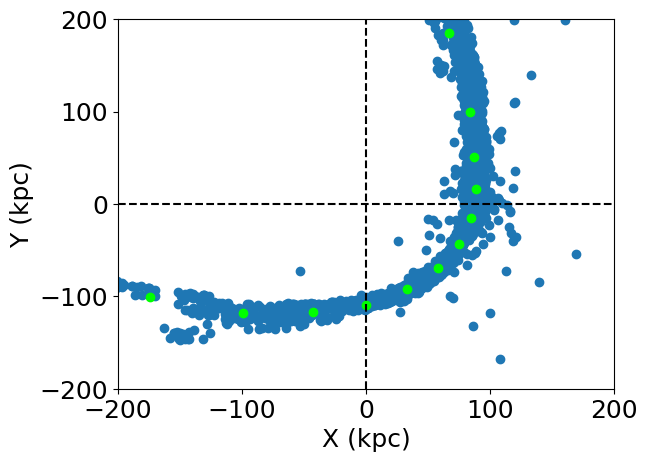

In [83]:
plt.scatter(xv_samples[:, 0], xv_samples[:, 1])
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')

In [ ]:
N = 100
other_seed = np.random.randint(1, 1000)

seed_r_chi2, r_chi2 = [], []
seed_r_chi, r_chi = [], []

seed_w_chi2, w_chi2 = [], []
seed_w_chi, w_chi = [], []
for i in tqdm(range(N), leave=True):

    with open(f"./MockStreams/seed{i}/dict_stream.pkl", "rb") as f:
        dict_data = pickle.load(f)

    params = dict_data['params']

    theta_stream_second, xv_stream_second, theta_sat_second, xv_sat_second, S, dS, T, dT, refs, samples = generate_stream_second(params,  seed=other_seed)
    theta_samples, xv_samples = inference_second(theta_stream_second, xv_stream_second, refs, S, T, seed=111, disp_x=0.3, disp_v=1.)
    count_first, theta_bin_first, r_bin, w_bin = get_track(theta_samples, xv_samples[:, 0], xv_samples[:, 1])

    r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]
    r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]

    w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > 100]
    w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > 100]

    r_chi2.extend((r_diff / dict_data['r_bin'][dict_data['count'] > 100]))
    r_chi.extend((r_bias / dict_data['r_bin'][dict_data['count'] > 100]))

    w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > 100]))
    w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > 100]))

    theta_stream, xv_stream, theta_sat, xv_sat = generate_stream_spray(params,  seed=other_seed)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])
    min_count = 100

    r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]
    r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]

    w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]
    w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]

    seed_r_chi2.extend((r_diff / dict_data['r_bin'][dict_data['count'] > min_count]))
    seed_r_chi.extend((r_bias / dict_data['r_bin'][dict_data['count'] > min_count]))

    seed_w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > min_count]))
    seed_w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > min_count]))

seed_r_chi2 = jnp.array(seed_r_chi2)
seed_r_chi = jnp.array(seed_r_chi)
r_chi2 = jnp.array(r_chi2)
r_chi = jnp.array(r_chi)

seed_w_chi2 = jnp.array(seed_w_chi2)
seed_w_chi = jnp.array(seed_w_chi)
w_chi2 = jnp.array(w_chi2)
w_chi = jnp.array(w_chi)

100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


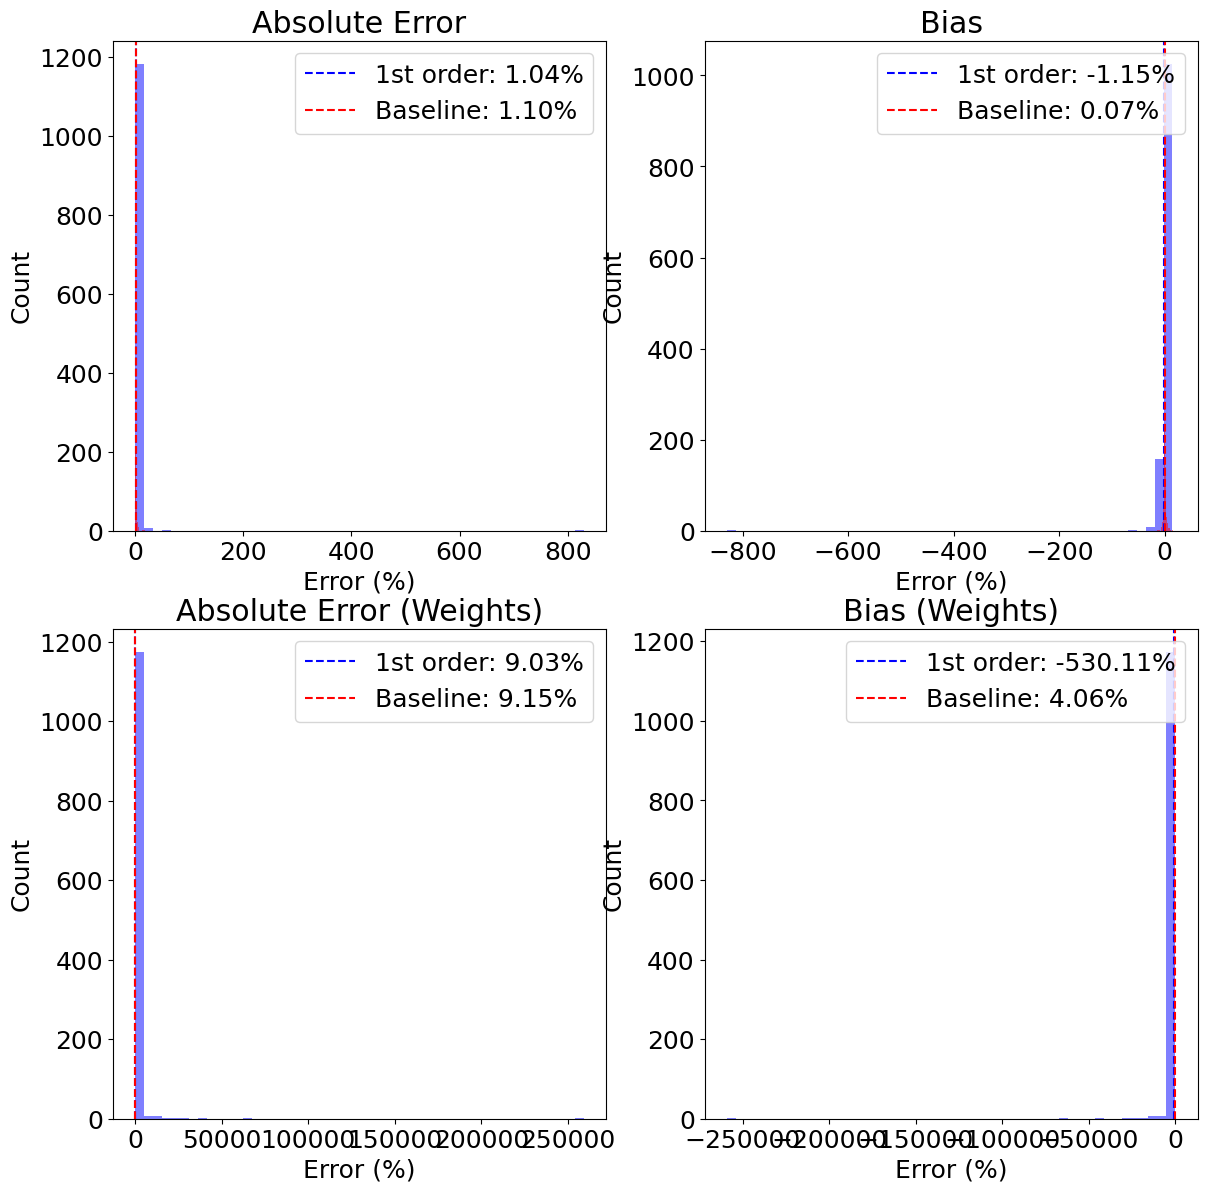

In [77]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.title('Absolute Error')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*r_chi2, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_r_chi2, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*r_chi2), color='b', linestyle='--', label=f'1st order: {np.median(100*r_chi2):.2f}%')
plt.axvline(np.median(100*seed_r_chi2), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_r_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.title('Bias')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*r_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_r_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.mean(100*r_chi), color='b', linestyle='--', label=f'1st order: {np.mean(100*r_chi):.2f}%')
plt.axvline(np.mean(100*seed_r_chi), color='r', linestyle='--', label=f'Baseline: {np.mean(100*seed_r_chi):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 3)
plt.title('Absolute Error (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi2, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi2, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*w_chi2), color='b', linestyle='--', label=f'1st order: {np.median(100*w_chi2):.2f}%')
plt.axvline(np.median(100*seed_w_chi2), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_w_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.title('Bias (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.mean(100*w_chi), color='b', linestyle='--', label=f'1st order: {np.mean(100*w_chi):.2f}%')
plt.axvline(np.mean(100*seed_w_chi), color='r', linestyle='--', label=f'Baseline: {np.mean(100*seed_w_chi):.2f}%')
plt.legend(loc='upper right')


## Compare

In [3]:
sigma = 2. # 2% radial noise

i = 5
with open(f"./MockStreams/seed{i}/dict_stream.pkl", "rb") as f:
    dict_data = pickle.load(f)

params_data = dict_data['params']
params_data = np.concatenate([params_data[:2], params_data[3:9], params_data[10:-1]])

r_sig = dict_data['r_bin'] * sigma / 100
rng   = np.random.default_rng(int(13))
r_err = rng.normal(0, r_sig)

dict_data['r_bin'] += r_err
dict_data['r_sig'] = r_sig
dict_data['x_bin'] = dict_data['r_bin'] * np.cos(dict_data['theta_bin'])
dict_data['y_bin'] = dict_data['r_bin'] * np.sin(dict_data['theta_bin'])
    
N = 500
spray_base, spray, streak, first = [], [], [], []
for n in tqdm(range(N)):
    spray_base.append(log_likelihood_spray_base(params_data, dict_data, seed=np.random.randint(1, 1000000), min_count=100))
    spray.append(log_likelihood_spray(params_data, dict_data, seed=np.random.randint(1, 1000000), min_count=100))
    streak.append(log_likelihood_streak(params_data, dict_data, seed=np.random.randint(1, 1000000), min_count=100))
    first.append(log_likelihood_first(params_data, dict_data, seed=np.random.randint(1, 1000000), min_count=100))
spray_base = np.array(spray_base)
spray = np.array(spray)
streak = np.array(streak)
first = np.array(first)

100%|██████████| 500/500 [03:04<00:00,  2.71it/s]


Text(0, 0.5, 'Count')

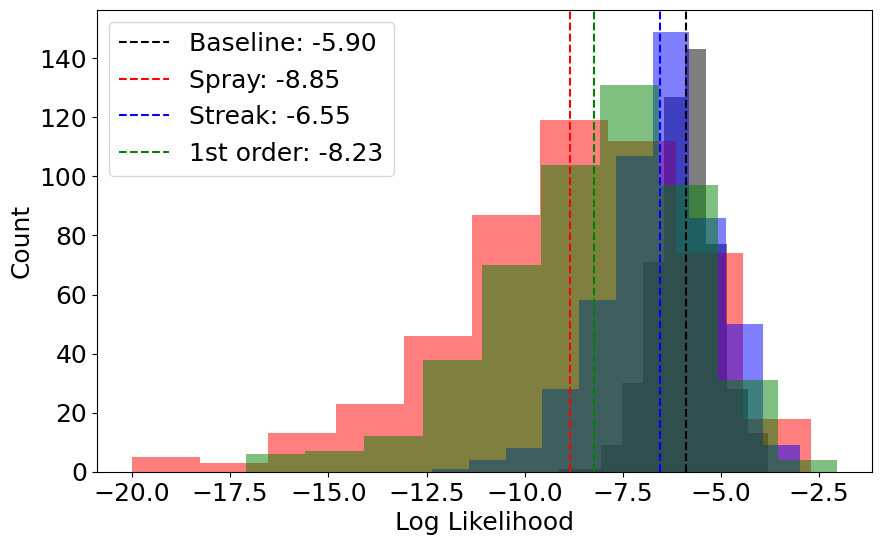

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(spray_base, bins=10, alpha=0.5, color='k')
plt.hist(spray, bins=10, alpha=0.5, color='r')
plt.hist(streak, bins=10, alpha=0.5, color='b')
plt.hist(first, bins=10, alpha=0.5, color='g')

plt.axvline(np.mean(spray_base), color='k', linestyle='--', label=f'Baseline: {np.mean(spray_base):.2f}')
plt.axvline(np.mean(spray), color='r', linestyle='--', label=f'Spray: {np.mean(spray):.2f}')
plt.axvline(np.mean(streak), color='b', linestyle='--', label=f'Streak: {np.mean(streak):.2f}')
plt.axvline(np.mean(first), color='g', linestyle='--', label=f'1st order: {np.mean(first):.2f}')
plt.legend(loc='best')
plt.xlabel('Log Likelihood')
plt.ylabel('Count')